In [5]:
import os

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

INTERIM_PATH = "../data/interim/"
MODELS_PATH = "../models/"
PATH_SAVE_FIGURES = "../reports/figures/"

# Prepare data for training

In [6]:
df_wide = pd.read_csv(os.path.join(INTERIM_PATH, "wide_and_deep_df_wide.csv"), index_col=0)
df_deep = pd.read_csv(os.path.join(INTERIM_PATH, "wide_and_deep_df_deep.csv"), index_col=0)

with open(os.path.join(INTERIM_PATH, 'wide_and_deep_X_train.pkl'), 'rb') as f:
    wide_inputs_train, categorical_input_1_train, categorical_input_2_train, categorical_input_3_train, numerical_input_train = pickle.load(f)
    
with open(os.path.join(INTERIM_PATH, 'wide_and_deep_X_test.pkl'), 'rb') as f:
   wide_inputs_test, categorical_input_1_test,categorical_input_2_test, categorical_input_3_test, numerical_input_test = pickle.load(f)
   
with open(os.path.join(INTERIM_PATH, 'wide_and_deep_Y_train.pkl'), 'rb') as f:
   y_train = pickle.load(f)
   
with open(os.path.join(INTERIM_PATH, 'wide_and_deep_Y_test.pkl'), 'rb') as f:
   y_test = pickle.load(f)
   
wide_inputs_train, categorical_input_1_train, categorical_input_2_train, categorical_input_3_train, numerical_input_train = torch.Tensor(wide_inputs_train), torch.Tensor(categorical_input_1_train).type(torch.int64), torch.Tensor(categorical_input_2_train).type(torch.int64), torch.Tensor(categorical_input_3_train).type(torch.int64), torch.Tensor(numerical_input_train)

wide_inputs_test, categorical_input_1_test,categorical_input_2_test, categorical_input_3_test, numerical_input_test = torch.Tensor(wide_inputs_test), torch.Tensor(categorical_input_1_test).type(torch.int64), torch.Tensor(categorical_input_2_test).type(torch.int64), torch.Tensor(categorical_input_3_test).type(torch.int64), torch.Tensor(numerical_input_test)

y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)


In [12]:
df_wide

,gender_occupation_F_administrator,gender_occupation_F_artist,gender_occupation_F_educator,gender_occupation_F_engineer,gender_occupation_F_entertainment,gender_occupation_F_executive,gender_occupation_F_healthcare,gender_occupation_F_homemaker,gender_occupation_F_lawyer,gender_occupation_F_librarian,...,gender_occupation_M_marketing,gender_occupation_M_none,gender_occupation_M_other,gender_occupation_M_programmer,gender_occupation_M_retired,gender_occupation_M_salesman,gender_occupation_M_scientist,gender_occupation_M_student,gender_occupation_M_technician,gender_occupation_M_writer
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
99998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
df_deep

,age,gender,occupation,genre
0,0.803030,1,15,2
1,0.803030,1,15,0
2,0.803030,1,15,5
3,0.803030,1,15,7
4,0.803030,1,15,3
...,...,...,...,...
99995,0.181818,1,18,0
99996,0.181818,1,18,0
99997,0.181818,1,18,0
99998,0.181818,1,18,3


# Deep learning model architecture

In [7]:
max_num_categorical_values = 50
emb_dimension = 64
max_sequence_length = 1

class WideAndDeepModel(nn.Module):
    def __init__(self, num_features):
        """Initialize model"""
        
        super(WideAndDeepModel, self).__init__()
        
        self.emb_1 = nn.Embedding(max_num_categorical_values, emb_dimension)
        self.emb_2 = nn.Embedding(max_num_categorical_values, emb_dimension)
        self.emb_3 = nn.Embedding(max_num_categorical_values, emb_dimension)
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.2)
        
        self.deep_layers = nn.Sequential(
            nn.Linear(3 * emb_dimension + 1, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        
        self.wide_inputs = nn.Linear(num_features, num_features)
        
        self.output = nn.Sequential(
                                    nn.Linear(105, 1), 
                                    nn.ReLU()
        )
        
    def forward(self, wide_inputs, categorical_input_1, categorical_input_2, categorical_input_3, numerical_input):
        """Forward function"""
        
        emb_1 = self.flatten(self.emb_1(categorical_input_1))
        emb_2 = self.flatten(self.emb_2(categorical_input_2))
        emb_3 = self.flatten(self.emb_3(categorical_input_3))
        
        concatenated_embeddings = torch.cat((emb_1, emb_2, emb_3, numerical_input), dim=1)
        concatenated_embeddings = self.dropout(concatenated_embeddings)
        
        deep_output = self.deep_layers(concatenated_embeddings)
        
        wide_input = self.wide_inputs(wide_inputs)
        combined = torch.cat((wide_input, deep_output), dim=1)
        combined = self.dropout(combined)
        
        wide_and_deep_output = self.output(combined)
        
        return wide_and_deep_output


num_features = len(df_wide.columns)
wide_and_deep_model = WideAndDeepModel(num_features)
print(wide_and_deep_model)

WideAndDeepModel(
  (emb_1): Embedding(50, 64)
  (emb_2): Embedding(50, 64)
  (emb_3): Embedding(50, 64)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (deep_layers): Sequential(
    (0): Linear(in_features=193, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=64, bias=True)
    (10): ReLU()
  )
  (wide_inputs): Linear(in_features=41, out_features=41, bias=True)
  (output): Sequential(
    (0): Linear(in_features=105, out_features=1, bias=True)
    (1): ReLU()
  )
)


# Training process

In [8]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.optim as optim

batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define optimizer and loss function
wide_and_deep_model = wide_and_deep_model.to(device)
optimizer = optim.Adam(wide_and_deep_model.parameters())
criterion = nn.MSELoss()

# Prepare your data in PyTorch DataLoader
train_dataset = TensorDataset(wide_inputs_train, categorical_input_1_train,
                              categorical_input_2_train, categorical_input_3_train,
                              numerical_input_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


# Training loop
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    wide_and_deep_model.train()  # Set model to training mode
    
    for i, data in enumerate(train_loader, 0):
        wide_inputs, cat_input_1, cat_input_2, cat_input_3, num_input, labels = data
        wide_inputs, cat_input_1, cat_input_2, cat_input_3, num_input, labels = wide_inputs.to(device), cat_input_1.to(device), cat_input_2.to(device), cat_input_3.to(device), num_input.to(device), labels.to(device)
    
        optimizer.zero_grad()
        
        outputs = wide_and_deep_model(wide_inputs, cat_input_1, cat_input_2, cat_input_3, num_input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Epoch - {epoch + 1}, loss = {running_loss / len(train_loader)}, rmse = {np.sqrt(running_loss / len(train_loader))}")
    losses.append(running_loss / len(train_loader))

Epoch - 1, loss = 1.4254490484952926, rmse = 1.193921709533457
Epoch - 2, loss = 1.2767514662981034, rmse = 1.1299342752116617
Epoch - 3, loss = 1.2632473044276238, rmse = 1.123942749621894
Epoch - 4, loss = 1.257342862200737, rmse = 1.1213130081296376
Epoch - 5, loss = 1.2527355213165283, rmse = 1.1192566824980446
Epoch - 6, loss = 1.2461453395843505, rmse = 1.1163088011766056
Epoch - 7, loss = 1.2479559756994247, rmse = 1.1171194992924547
Epoch - 8, loss = 1.2432968809008598, rmse = 1.1150322331219218
Epoch - 9, loss = 1.2418999582648278, rmse = 1.1144056524734733
Epoch - 10, loss = 1.239729526400566, rmse = 1.1134314197114101
Epoch - 11, loss = 1.2404740032911301, rmse = 1.1137656859910572
Epoch - 12, loss = 1.2368287499785424, rmse = 1.1121280276921999
Epoch - 13, loss = 1.235861572599411, rmse = 1.1116931107996537
Epoch - 14, loss = 1.2341927841901779, rmse = 1.1109422956167336
Epoch - 15, loss = 1.2336290060043336, rmse = 1.1106885278980483
Epoch - 16, loss = 1.232300968360901, r

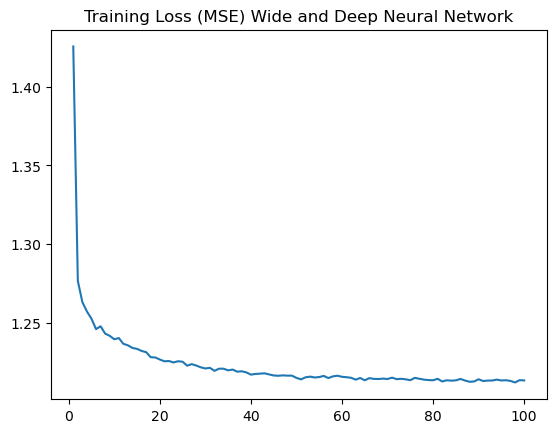

In [9]:
epoch_list = [(i+1) for i in range(num_epochs)]
plt.plot(epoch_list, losses)
plt.title('Training Loss (MSE) Wide and Deep Neural Network')
plt.savefig(os.path.join(PATH_SAVE_FIGURES, "wide_and_deep_loss.png"), bbox_inches = 'tight')
plt.show()

# Evaluation

In [10]:
# Prepare data in PyTorch DataLoader
test_dataset = TensorDataset(wide_inputs_test, categorical_input_1_test,
                              categorical_input_2_test, categorical_input_3_test,
                              numerical_input_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

mse = 0
with torch.no_grad():
    wide_and_deep_model.eval()
    for i, data in enumerate(test_loader, 0):
        wide_inputs, cat_input_1, cat_input_2, cat_input_3, num_input, labels = data
        wide_inputs, cat_input_1, cat_input_2, cat_input_3, num_input, labels = wide_inputs.to(device), cat_input_1.to(device), cat_input_2.to(device), cat_input_3.to(device), num_input.to(device), labels.to(device)
        outputs = wide_and_deep_model(wide_inputs, cat_input_1, cat_input_2, cat_input_3, num_input)

        loss = criterion(outputs, labels)
        mse += loss.item()

print(f'MSE = {mse / len(test_loader)}, RMSE = {np.sqrt(mse / len(test_loader))}')

MSE = 1.2150581442832946, RMSE = 1.1022967587193997


# Save model

In [11]:
torch.save(wide_and_deep_model.state_dict(), os.path.join(MODELS_PATH, "wide_and_deep_model.pt"))